In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Autoencoders

## Noción de Autoencoder



Un autoencoder es una arquitectura de red neuronal que nos permite representar un vector de características $x_i$ en un espacio latente con menor dimensionalidad, intentando perder la mínima información. Podemos interpretar los autoencoders como una técnica de reducción dimensional no lineal.

Para ello se crea una arquitectura con las siguientes partes:

* Encoder: Se encarga de transformar el vector $x_i$ en el vector $z_j$ de dimensionalidad reducida.  Para que la red no aprenda simplemente a copiar el vector original i > j.

  $enc(x_i, \theta_i^{enc}) = z_j$

* Decoder: Se encarga de reconstruir el vector $z_j$ en el vector $\hat{x_i}$ tratando de que sea lo más similar posible al vector original.

  $dec(z_j , \theta_i^{dec}) = \hat{x_i}$


Por lo tanto si componemos el encoder y el decoder tenemos: 
  
  &nbsp;&nbsp;&nbsp;&nbsp;$dec(enc(x_i, \theta_i^{enc}), \theta_i^{dec}) =  \hat{x_i}$
  
De esta manera podemos entrenar los paramétros $ \theta_i^{enc}$  y $, \theta_i^{dec}$ para optimizar una función de pérdidas que minimice la diferencia entre el vector original y el vector reconstruido. 

![esquema](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

## MNIST dataset

Para ilustrar la teoría vamos a utilizar el conocido dataset MNIST.

Este dataset esta formado por 70 000 imagénes con una resolución de 28x28 píxeles en blanco y negro (es decir, con sólo un canal) que representan los digitos del 1 al 9 escritos a mano por diferentes personas.

In [0]:
# Cargamos los datos del repositorio de openML.

from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X /= 255 # Normalizamos los píxeles entre 0 y 1

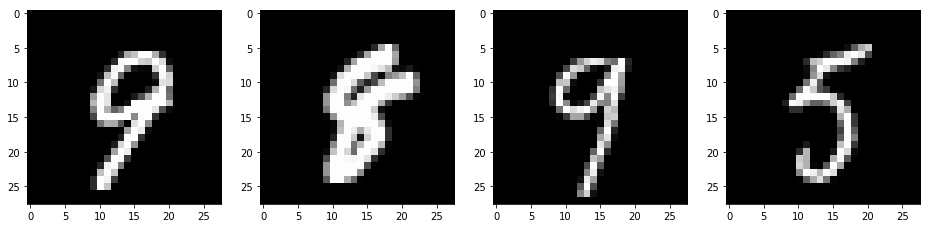

In [0]:
# Mostramos una muestra de 4 digitos elegidos aleatoriamente.

fig, axes = plt.subplots(1, 4)

fig.set_figheight(4)
fig.set_figwidth(16)

for ax in axes:
  ax.imshow(X[np.random.randint(0, X.shape[0]), ].reshape(28, 28), cmap="gray")

## Vanilla autoencoders

Para construir el autoencoder vamos a utilizar el framework *Pytorch*.

Como ejemplo vamos a construir una red con una sóla capa oculta para el encoder y otra para el decoder, y vamos a dejar como parámetro el número de dimensiones que queremos que tenga el espacio latente.

Así mismo vamos a aplicar una tangente hiperbólica a la salida del encoder para que mapee el espacio latente a (-1, 1) y sea más sencillo de interpretar.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [0]:
class Autoencoder(nn.Module):
  """ Representa un modulo de autoencoder. En este caso el encoder solo tiene 
  una capa oculta densa, igual que el decoder. Esperan tensores de dos 
  dimensiones, el tamaño del batch y el número de features.
  """
  
  def __init__(self, input_dim, hidden_dim, latent_space_dim):
    """ Constructor del objeto.
    Args:
      input_dim (int): Dimensionalidad del vector de input.
      hidden_dim (int): Dimensión de la capa oculta del encoder y el decoder.
      latent_space_dim (int): Dimensión del espacio latente, bottleneck.
    """  

    super().__init__() # Inicializa la clase base.
    
    # Construcción del encoder.
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, latent_space_dim),
        nn.Tanh()
    )
    # Construcción del decoder.
    self.decoder = nn.Sequential(
        nn.Linear(latent_space_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, input_dim)
    )
    
  def reconstruct(self, x):
    """ Reconstruye el vector pasando por el autoencoder.
    Args:
      x (torch.FloatTensor): Tensor de entrada.
    Returns:
      Tensor de la misma forma reconstruido.
    """
    return self.decoder(self.encoder(x))
  
  def encode(self, x):
    """ Codifica el tensor reduciendolo a la dimensionalidad del espacio 
    latente.
    Args:
      x (torch.FloatTensor): Tensor de entrada.
    Returns:
      Tensor con la dimensionalidad del espacio latente.
    """
    return self.encoder(x)
  
  def decode(self, z):
    """ Decodifica un vector en el espacio latente a un vector en el espacio
    original.
    Args:
      z (torch.FloatTensor): Tensor de entrada en el espacio latente.
    Returns:
      Tensor en el espacio original.
    """
    return self.decoder(z)
  
  def fit(self, x, n_epoch = 10, verbose = True):
    """ Entrena el autoencoder.
    Args:
      x (torch.FloatTensor): Dataset de entrada.
      n_epoch (int): Numero de epoch a ejecutar.
      verbose (bool): Indica si se muestra el progreso.
    """ 
    
    # Elegimos como método de optimización Adam.
    optimizer = optim.Adam(self.parameters())
    # Como función de pérdida tomamos el error cuadratico medio.
    loss_function = nn.MSELoss()
    
    # Iteramos durante n_epoch epoch. Nótese que estamos haciendo 
    # batch optimization, es decir, actualizamos la red una vez
    # por epoch utilizando el gradiente de todo el dataset. Podría
    # ser más eficiente hacer mini-batches con los datos.
    for ep in range(n_epoch):
      
      # Calculamos la pérdida
      loss = loss_function(self.reconstruct(x), x)
      # Sacamos por pantalla si se especifica.      
      if verbose:
        print(f"\r[{ep + 1}] Loss: {loss.item():.5f}", end = "")

      optimizer.zero_grad() # Reseteamos los gradientes actuales.
      loss.backward() # Calculamos los gradientes con la pérdida.
      optimizer.step() # Actualizamos los pesos con el optimizador.

#### Autoencoder con espacio latente bidimensional


Entrenamos ahora el autoencoder con un espacio latente de dos dimensiones para que sea fácilmente interpretable con los datos de MNIST. Hemos definido un entrenamiento con todo el batch de los datos aunque sería más eficiente entrenarlo con mini batches.

In [0]:
torch.manual_seed(0) # Fijo la semilla para que sea reproducible.

# Construcción del autoencoder con la dimensionalidad de entrada 28x28=784,
# una capa oculta con 128 neuronas y una dimensión del espacio latente de 2.
mnist_ae = Autoencoder(784, 128, 2)

# Convierto el dataset en numpy a un tensor de torch.
x = torch.FloatTensor(X)

# Si se puede entrenar con GPU paso los tensores a la memoria de la GPU.
if torch.cuda.is_available():
  mnist_ae = mnist_ae.cuda()
  x = x.cuda()
  print("Using GPU backend.")
else:
  print("Using CPU backend")

# Fijo el modo entrenamiento aunque no es necesario porque por defecto está 
# activado.
mnist_ae.train()

# Ejecuta el entrenamiento
mnist_ae.fit(x, n_epoch = 5000)

Using GPU backend.
[5000] Loss: 0.03817

In [0]:
%%capture
# Fijo el modo inferencia para el modelo.
mnist_ae.eval()

Una vez entrenados los parámetros de la red, proyectamos todas las imagenes al espacio latente de dos dimensiones para visualizar cómo coloca la red cada una de las imágenes.

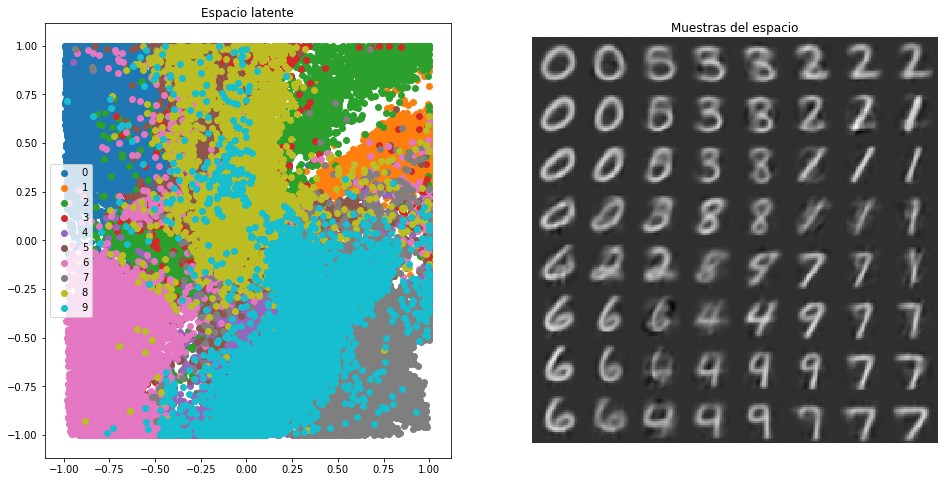

In [0]:
# Proyecta todo el dataset al espacio latente.
encoded = mnist_ae.encode(x).cpu().detach().numpy()

# Creo la figura y los ejes para representar.
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(8 * 2)

# Pinto el scatter
for i in range(10):
  pos = y == str(i)
  ax.scatter(encoded[pos, 0], encoded[pos, 1], label = str(i))
ax.set_title("Espacio latente")
ax.legend()

# Pinta las imagenes
points = np.linspace(-1.00 + 0.25 * 0.5, 1.00 - 0.25 * 0.5, 8)
img_array = []
for i in reversed(range(8)):
  
  img_array.append([])
  
  for j in range(8):
    
    im = mnist_ae.decode(
        torch.FloatTensor([points[j], points[i]]).cuda()
    ).detach().cpu().numpy().reshape(28, 28)
    img_array[-1].append(im)
    
ax2.imshow(np.block(img_array), cmap = "gray")
ax2.set_title("Muestras del espacio")
ax2.axis('off')

# Muestra la figura
plt.show()

Cada punto de la figura de la izquierda representa una imagen del dataset. Sus coordenadas representan las dimensiones del espacio latente obtenidas y su color el número que representan (notése que no hemos utilizado la etiqueta para el entrenamiento). Como podemos observar el autoencoder agrupa automáticamente los números en clusters en función de su forma por lo que los números más parecidos quedan cercanos entre sí. Por ejemplo la transición 4 -9 - 7.

La figura de la izquierda representa números generados a partir del espacio latente en la posición de su centro. Es decir la imagén (0, 0) esta generada con el decoder con un valor de entrada (-8.750, 8.750). Se puede observar que las imágenes generadas corresponden al cluster en que se encuentran. La relación no es, y no tiene porqué ser lineal.

#### Autoencoder en espacios de mayor dimensionalidad

A medida que aumentamos la dimensionalidad del espacio latente el modelo es capaz de conservar más información de la imagen de entrada. 

Para ilustrarlo vamos a entrenar autoencoders con un espacio latente de dimensionalidad creciente.

In [0]:
torch.manual_seed(0) # Semilla para reproducibilidad

ae_list = [] # Lista de autoencoders
dims = [2, 16, 32] # Lista de dimensiones de espacio latente.

for dim in dims: # Para cada dimension definida.
  
  # Construye el autoencoder con la dimension.
  mnist_ae = Autoencoder(784, 128, dim)
  x = torch.FloatTensor(X) # Transformamos numpy en tensor.
  
  # Si hay gpu pasamos los tensores y el modelo a la GPU.
  if torch.cuda.is_available():
    mnist_ae = mnist_ae.cuda()
    x = x.cuda()
    print("Using GPU backend.")
  else:
    print("Using CPU backend")
  
  # Entrenamos.
  print(f"Fiting autoencoder with latent espace of dim: {dim}")
  mnist_ae.fit(x, n_epoch = 5000)
  print()
  
  # Añadimos el autoencoder a la lista de autoencoders entrenados.
  ae_list.append(mnist_ae)

Using GPU backend.
Fiting autoencoder with latent espace of dim: 2
[5000] Loss: 0.03817
Using GPU backend.
Fiting autoencoder with latent espace of dim: 16
[5000] Loss: 0.01577
Using GPU backend.
Fiting autoencoder with latent espace of dim: 32
[5000] Loss: 0.01170


A continuación, vamos a representar una muestra de imagenes reales y su reconstrucción por cada uno de los autoencoders generados.

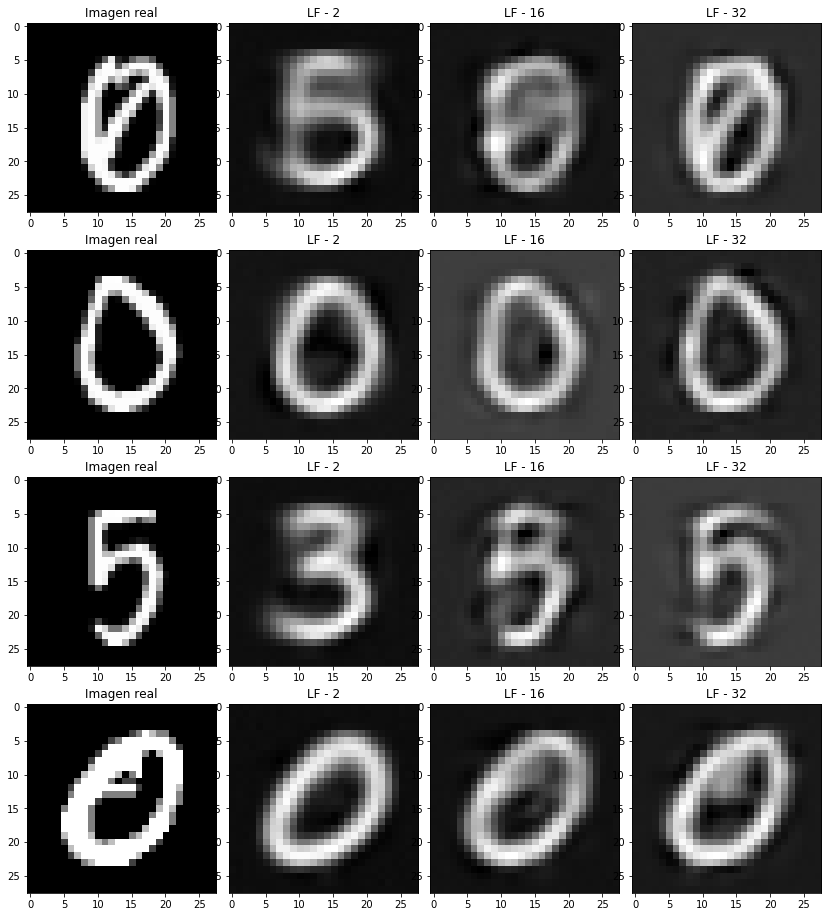

In [0]:
np.random.seed(1) # Semilla para reproducibilidad

n_samples = 4 # Numero de muestras a representar.

# Sampleamos el dataset original.
sample = x[np.random.choice(x.shape[0], n_samples)]

# Reconstruimos la imagen para cada uno de los autoencoders
sample_r = [
    ae.reconstruct(sample).detach().cpu().numpy()
    for ae in ae_list
]
 
# Pintamos las imagenes.

fig, axes = plt.subplots(n_samples, 1 + len(ae_list))

fig.set_figwidth(16)
fig.set_figheight(4 * n_samples)

for i in range(n_samples):
  
  ax = axes[i]
  
  real = sample[i, :].cpu().numpy()
    
  ax[0].set_title("Imagen real")
  ax[0].imshow(real.reshape(28, 28), cmap = "gray")
  
  for j in range(len(ae_list)):
    
    ax[j + 1].set_title(f"LF - {dims[j]}")
    ax[j + 1].imshow(sample_r[j][i].reshape(28, 28), cmap = "gray")

plt.subplots_adjust(hspace=0.2, wspace=-0.3)

plt.show()
  

Como se puede observar en las imágenes superiores, a medida que el espacio latente

## Denoiser autoencoders

Un caso de uso de los autoencoders es la eliminación de ruido del input para reconstruir un output limpio de ruido.

Para ello transformamos el vector de entrada añadiendo algún tipo de ruido y entrenamos el modelo para reconstruir la imagen original.

$\hat{x}_i = F(\theta_i, x_i + r_i)$

### Ruido *dropout*

En el primer caso vamos a probar con un ruido que hace que algunos píxeles de la imagen se pierdan (es decir los pone a cero).

In [0]:
class DenoiserAutoencoder(Autoencoder):
  """ Autoencoder entrenado para eliminar ruido de los vectores
  de entrada.
  """
  
  def __init__(self, *args,  epsilon = 0.2, **kwargs):
    """
    Args:
      args: Parámetros de entrada de Autoencoder.
      epsilon (float): Porcentaje de ruido a añadir.
      kwargs: Parámetros de entrad de Autoencoder.
    """
    self.epsilon = epsilon
    super().__init__(*args, **kwargs)
  
  def reconstruct(self, x):
    """ Reconstruye la imagen. En modo entrenamiento 
    añade ruido a la imagen.
    Args:
      x (torch.FloatTensor): Vector de entrada al entrenamiento.
    Returns:
      Vector x sin ruido (idealmente).
    """
    
    # Si esta en modo entrenamiento añadimos ruido al
    # input con una probabilidad epsilon.
    if  self.training:
      x = self.add_noise(x)
      
    return super().reconstruct(x)
  
  def add_noise(self, x):
    """ Añade ruido al tensor de entrada.
    Args:
      x (torch.FloatTensor): Vector de entrada al entrenamiento.
    Returns:
      Vector x con ruido.
    """
    return nn.Dropout(p=self.epsilon)(x)
      

In [0]:
torch.manual_seed(0) # Fijo la semilla para que sea reproducible.

epsilon = 0.5

# Construcción del autoencoder con la dimensionalidad de entrada 28x28=784,
# una capa oculta con 128 neuronas y una dimensión del espacio latente de 2.
dae = DenoiserAutoencoder(784, 128, 32, epsilon = epsilon)


# Convierto el dataset en numpy a un tensor de torch.
x = torch.FloatTensor(X)

# Si se puede entrenar con GPU paso los tensores a la memoria de la GPU.
if torch.cuda.is_available():
  dae = dae.cuda()
  x = x.cuda()
  print("Using GPU backend.")
else:
  print("Using CPU backend")

# Fijo el modo entrenamiento aunque no es necesario porque por defecto está 
# activado.
dae.train()

# Ejecuta el entrenamiento
dae.fit(x, n_epoch = 5000)

Using GPU backend.
[5000] Loss: 0.01633

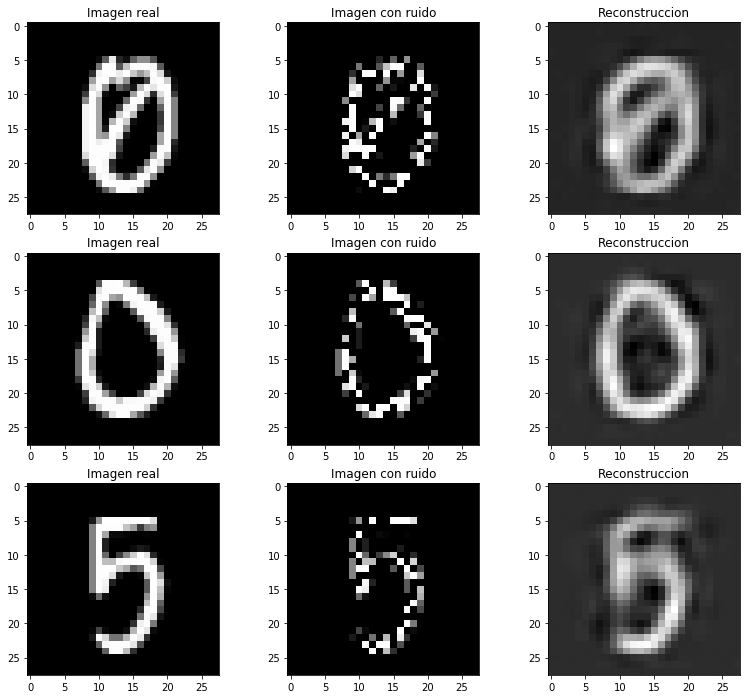

In [0]:
n_samples = 3


dae.eval()

np.random.seed(1)

sample = x[np.random.choice(x.shape[0], n_samples)]

noisy = dae.add_noise(sample)

reconst = dae.reconstruct(noisy)

fig, axes = plt.subplots(n_samples, 3)

fig.set_figwidth(16)
fig.set_figheight(4 * n_samples)

for i in range(n_samples):
  
  ax = axes[i]
  
  real = sample[i, :].cpu().numpy()
    
  ax[0].set_title("Imagen real")
  ax[0].imshow(real.reshape(28, 28), cmap = "gray")
  
  noi = noisy[i, :].cpu().numpy()
  ax[1].set_title("Imagen con ruido")
  ax[1].imshow(noi.reshape(28, 28), cmap = "gray")
  
  rec = reconst[i, :].cpu().detach().numpy()
  
  ax[2].set_title("Reconstruccion")
  ax[2].imshow(rec.reshape(28, 28), cmap = "gray")

plt.subplots_adjust(hspace=0.2, wspace=-0.3)

plt.show()

### Ruido uniforme

Probamos con un ruido uniforme por toda la imagen.

In [0]:
class UniformDenoiserAutoencoder(DenoiserAutoencoder):
  """ Autoencoder entrenado para eliminar ruido de los vectores
  de entrada.
  """
  
  def add_noise(self, x):
    """ Añade ruido al tensor de entrada.
    Args:
      x (torch.FloatTensor): Vector de entrada al entrenamiento.
    Returns:
      Vector x con ruido.
    """
    # Ojo que se genera en cuda habria que implementar algo generico
    dist = torch.distributions.Uniform(-0.75, 0.75)
    return torch.clamp(x + dist.sample(x.shape).cuda(), 0, 1)
    

In [0]:
torch.manual_seed(0) # Fijo la semilla para que sea reproducible.

epsilon = 0.5

# Construcción del autoencoder con la dimensionalidad de entrada 28x28=784,
# una capa oculta con 128 neuronas y una dimensión del espacio latente de 2.
dae = UniformDenoiserAutoencoder(784, 128, 32, epsilon = epsilon)


# Convierto el dataset en numpy a un tensor de torch.
x = torch.FloatTensor(X)

# Si se puede entrenar con GPU paso los tensores a la memoria de la GPU.
if torch.cuda.is_available():
  dae = dae.cuda()
  x = x.cuda()
  print("Using GPU backend.")
else:
  print("Using CPU backend")

# Fijo el modo entrenamiento aunque no es necesario porque por defecto está 
# activado.
dae.train()

# Ejecuta el entrenamiento
dae.fit(x, n_epoch = 5000)

Using GPU backend.
[5000] Loss: 0.01716

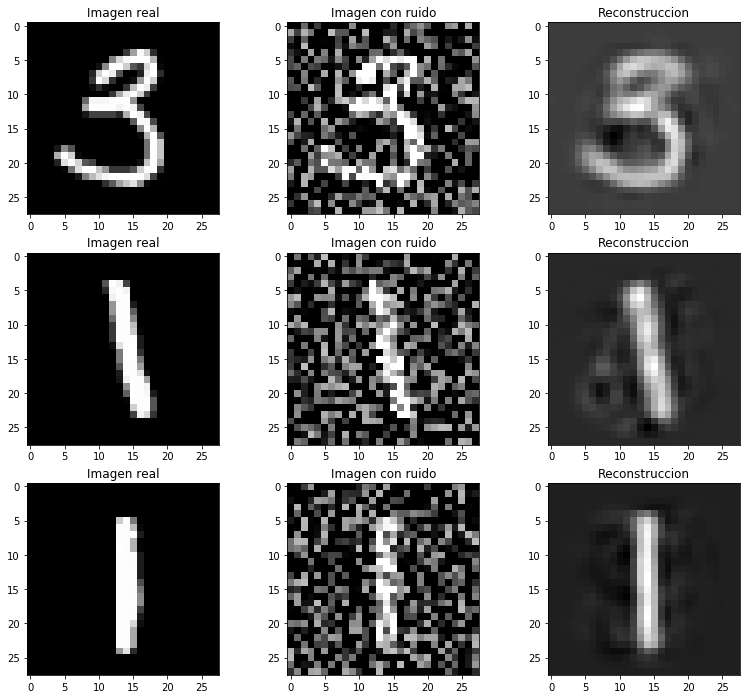

In [0]:
n_samples = 3


dae.eval()

np.random.seed(13)

sample = x[np.random.choice(x.shape[0], n_samples)]

noisy = dae.add_noise(sample)

reconst = dae.reconstruct(noisy)

fig, axes = plt.subplots(n_samples, 3)

fig.set_figwidth(16)
fig.set_figheight(4 * n_samples)

for i in range(n_samples):
  
  ax = axes[i]
  
  real = sample[i, :].cpu().numpy()
    
  ax[0].set_title("Imagen real")
  ax[0].imshow(real.reshape(28, 28), cmap = "gray")
  
  noi = noisy[i, :].cpu().numpy()
  ax[1].set_title("Imagen con ruido")
  ax[1].imshow(noi.reshape(28, 28), cmap = "gray")
  
  rec = reconst[i, :].cpu().detach().numpy()
  
  ax[2].set_title("Reconstruccion")
  ax[2].imshow(rec.reshape(28, 28), cmap = "gray")

plt.subplots_adjust(hspace=0.2, wspace=-0.3)

plt.show()